In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from itertools import combinations
from scipy import sparse

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
ratings = pd.read_csv('ml-1m/ratings.dat', header=None, sep='::', 
                      encoding='latin-1', engine='python', 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])
users = pd.read_csv('ml-1m/users.dat', header=None, sep='::',
                    encoding='latin-1', engine='python',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
movies = pd.read_csv('ml-1m/movies.dat', header=None, sep='::',
                     encoding='latin-1', engine='python',
                     names=['movie_id', 'title', 'genres'])

In [3]:
ratings['user_id'] = ratings['user_id'] - 1
ratings['movie_id'] = ratings['movie_id'] - 1
users['user_id'] = users['user_id'] - 1
movies['movie_id'] = movies['movie_id'] - 1

In [4]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [5]:
ratings.shape

(1000209, 4)

In [6]:
user_n = ratings['user_id'].nunique()
item_n = movies['movie_id'].nunique()
print("Number of users: {}".format(user_n))
print("Number of items: {}".format(item_n))

Number of users: 6040
Number of items: 3883


In [7]:
id_to_iid = {movies['movie_id'][i]:i for i in movies.index}
iid_to_id = {i:movies['movie_id'][i] for i in movies.index}


**Genre popularity**

In [8]:
movies.genres.str.split('|').explode().value_counts().sort_values(ascending=False)

Drama          1603
Comedy         1200
Action          503
Thriller        492
Romance         471
Horror          343
Adventure       283
Sci-Fi          276
Children's      251
Crime           211
War             143
Documentary     127
Musical         114
Mystery         106
Animation       105
Fantasy          68
Western          68
Film-Noir        44
Name: genres, dtype: int64

## Extract Movie Feature Vectors From Genre Information

Use tf-idf, a weighted frequecy, of each genre word as a feature.

In [9]:
tf =  TfidfVectorizer(analyzer=lambda x: (c for i in range(1, 4) for c in combinations(x.split('|'), r=i)))

This vectorizer transforms a movie's genre description into a list of tokens, where each token is a subsequence of the genres.

In [10]:
analyzer = tf.build_analyzer()
[token for token in analyzer('Action|Crime|Drama')]

[('Action',),
 ('Crime',),
 ('Drama',),
 ('Action', 'Crime'),
 ('Action', 'Drama'),
 ('Crime', 'Drama'),
 ('Action', 'Crime', 'Drama')]

Get the weighted frequency of each token and form the feature vector of this movie.

In [11]:
X_tfidf = tf.fit_transform(movies['genres'])
X_tfidf.shape

(3883, 353)

3883 movies, each has a feature vector of length 353 (which is the number of combinations of all the possible genres). Some of the movies are not in the dataset.

## Similarity 

In [12]:
sim = cosine_similarity(X_tfidf)

In [13]:
sim_df = pd.DataFrame(sim, index=movies['title'], columns=movies['title'])
sim_df.sample(5, axis=0).sample(5, axis=1).round(2)

title,"Edge, The (1997)",Metroland (1997),"Man with the Golden Gun, The (1974)",From the Journals of Jean Seberg (1995),Newsies (1992)
title,,,,,
Six Degrees of Separation (1993),0.00,0.39,0.0,0.0,0.0
Under the Rainbow (1981),0.00,0.45,0.0,0.0,0.0
"Relic, The (1997)",0.00,0.00,0.0,0.0,0.0
Dead Calm (1989),0.41,0.00,0.0,0.0,0.0
Steel Magnolias (1989),0.00,0.39,0.0,0.0,0.0


## Content-based Filtering

In [14]:
train_df, test_df = train_test_split(ratings, test_size=0.2)

In [15]:
train_df.shape

(800167, 4)

In [16]:
def df_to_mat(df):
    """
    Convert DataFrame to sparse matrix.

    Arg:
        df: DataFrame, ratings dataframe with user_id, movie_id and rating

    Return:
        mat: scipy.sparse.csr_matrix, sparse ratings matrix with rows being items and cols being users
    """
    
    mat = sparse.lil_matrix((item_n, user_n))
    for _, row in df.iterrows():
        user_id = int(row[0])
        item_id = int(row[1])
        item_iid = id_to_iid[item_id]
        rating = row[2]
        mat[item_iid, user_id] = rating
    
    return mat 

In [17]:
item_user_mat = df_to_mat(train_df)
item_user_mat = item_user_mat.tocsr()
sparse.save_npz('ml-1m/item_user_mat.npz', item_user_mat)
item_user_mat.shape

(3883, 6040)

In [ ]:
item_user_mat = sparse.load_npz('ml-1m/item_user_mat.npz')

In [18]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
# fit the sparse matrix to the k nearest neighbor model
knn.fit(X_tfidf)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [19]:
def cb_recommend(user_id, topk):
    
    user_ratings = item_user_mat[:, user_id]
    rated_before = np.nonzero(user_ratings)[0]
    sorted_rated_before = rated_before[np.argsort(user_ratings[rated_before].toarray().squeeze())][::-1]

    if sorted_rated_before.size > 0:
        # the user has at least one reviewed item
        raw_recommends = {}
        for item_iid in sorted_rated_before:
            distances, indices = knn.kneighbors(X_tfidf[item_iid], n_neighbors=topk+1)
            sorted_pairs = sorted(list(zip(indices.squeeze().tolist(),
                                           distances.squeeze().tolist())),
                                  key=lambda x: x[1])
            raw_recommends[item_iid] = sorted_pairs
        
        # get the top 10 items
        top_items = []
        pos = 0
        while True:
            for item_iid in sorted_rated_before:
                next_neighbor_iid = raw_recommends[item_iid][pos][0]
                if next_neighbor_iid not in rated_before:
                    top_items.append(iid_to_id[next_neighbor_iid])
                if len(top_items) > topk - 1:
                    return (user_id, np.array(top_items))
            
            pos += 1
    else:
        # the user has no review
        top_items = list(map(lambda x: iid_to_id[x], random.sample(list(range(0, item_n)), topk)))
        return (user_id, np.array(top_items))

In [33]:
cb_recommend(110, 10)

(110,
 array([ 864,  223,  163,  864, 3002, 1222, 1241,  864,  864, 1408],
       dtype=int64))

**Make recommendations for all the users**

In [ ]:
res = []
for user in range(user_n):
    res.append(cb_recommend(user, 5))
user_recs_allinclude = {x[0]:x[1] for x in res}

In [ ]:
df = pd.DataFrame(user_recs_allinclude)
df.to_csv('user_recs_allinclude_df.csv', index=False)

## Collaborative Filtering

In [49]:
mf = NMF(n_components=40, init='random', random_state=0, max_iter=500, verbose=False)


known_rating_mat = item_user_mat.T
user_f = mf.fit_transform(known_rating_mat)
item_f = mf.components_.T
est_rating_mat = np.dot(user_f, item_f.T)

In [50]:
def cf_recommend(user_id, topk):
    
    user_ratings = known_rating_mat[user_id, :]
    rated_before = np.nonzero(user_ratings)[1]
    estimations = est_rating_mat[user_id, :].copy()
    estimations[rated_before] = 0

    top_item_iids = np.argsort(-estimations)[:topk]
    top_ratings = -np.sort(-estimations)[:topk]

    top_item_ids = [iid_to_id[i] for i in top_item_iids]

    return (user_id, np.array(top_item_ids))


## Evaluation

In [51]:
import math
# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) # topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))

In [52]:
test_df.shape

(200042, 4)

In [53]:
test_mat = df_to_mat(test_df)
test_rating_mat = test_mat.T
all_rating_mat = test_rating_mat + known_rating_mat
all_rating_mat = all_rating_mat.toarray()

In [54]:
f_users = users[users['gender'] == 'F']
m_users=  users[users['gender'] == 'M']

### Evaluation of content-based filtering and collaborative filtering on 100 F and 100 M (20 runs)

In [55]:
def sample_evaluate(test_user_ids, recommender):

    r = []
    p = []
    n = []
    
    for user_id in test_user_ids:
        test_items_iids = list(np.argwhere(test_mat[:, user_id] >= 4)[:, 0])
        test_items = list(map(lambda x: iid_to_id[x], test_items_iids))

        if len(test_items) > 0:
            if recommender == 'content':
                top_items = list(cb_recommend(user_id, 10)[1])
            elif recommender == 'collaborative':
                top_items = list(cf_recommend(user_id, 10)[1])
            else:
                raise ValueError("Value of recommender must be either content or collaborative.")
        
            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)
            ndcg = nDCG_Time(test_items, top_items)

            r.append(recall)
            p.append(precision)
            n.append(ndcg)
    
    return (np.average(r),np.average(p),np.average(n))

In [34]:
all_f_cb_r = []
all_f_cb_p = []
all_f_cb_n = []

all_m_cb_r = []
all_m_cb_p = []
all_m_cb_n = []

all_f_cf_r = []
all_f_cf_p = []
all_f_cf_n = []

all_m_cf_r = []
all_m_cf_p = []
all_m_cf_n = []

epochs = 20

for epoch in range(epochs):
    test_f_user_ids = f_users.sample(100)['user_id'].to_numpy()
    test_m_user_ids = m_users.sample(100)['user_id'].to_numpy()

    # evaluation of content-based filtering on female users
    f_cb_r, f_cb_p, f_cb_n = sample_evaluate(test_f_user_ids, 'content')
    all_f_cb_r.append(f_cb_r)
    all_f_cb_p.append(f_cb_p)
    all_f_cb_n.append(f_cb_n)

    # evaluation of content-based filtering on male users
    m_cb_r, m_cb_p, m_cb_n = sample_evaluate(test_m_user_ids, 'content')
    all_m_cb_r.append(m_cb_r)
    all_m_cb_p.append(m_cb_p)
    all_m_cb_n.append(m_cb_n)

    # evaluation of collaborative filtering on female users
    f_cf_r, f_cf_p, f_cf_n = sample_evaluate(test_f_user_ids, 'collaborative')
    all_f_cf_r.append(f_cf_r)
    all_f_cf_p.append(f_cf_p)
    all_f_cf_n.append(f_cf_n)

    # evaluation of collaborative filtering on male users
    m_cf_r, m_cf_p, m_cf_n = sample_evaluate(test_m_user_ids, 'collaborative')
    all_m_cf_r.append(m_cf_r)
    all_m_cf_p.append(m_cf_p)
    all_m_cf_n.append(m_cf_n)
    

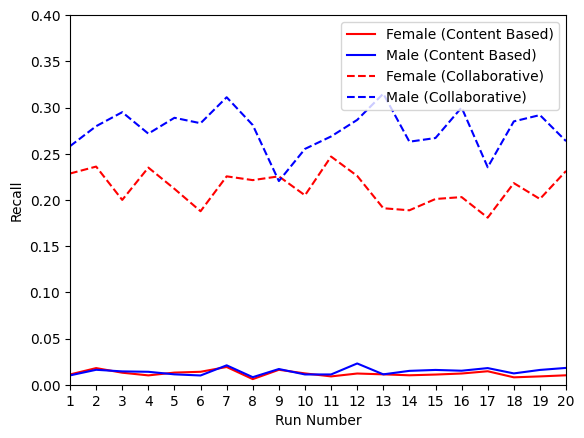

In [57]:
fig, ax = plt.subplots()
ax.plot(np.arange(epochs)+1, all_f_cb_r, 'r', label='Female (Content Based)')
ax.plot(np.arange(epochs)+1, all_m_cb_r, 'b', label='Male (Content Based)')
ax.plot(np.arange(epochs)+1, all_f_cf_r, 'r--', label='Female (Collaborative)')
ax.plot(np.arange(epochs)+1, all_m_cf_r, 'b--', label='Male (Collaborative)')
legend = ax.legend(loc='upper right')
ax.set_xlim([1,epochs])
ax.set_ylim([0, 0.4])
ax.set_xlabel('Run Number')
ax.set_ylabel('Recall')
plt.xticks(range(1,epochs+1))
plt.show()

In [58]:
print('Content Based Filtering Female:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_f_cb_r), np.std(all_f_cb_r)))
print('Content Based Filtering Male:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_m_cb_r), np.std(all_m_cb_r)))
print('Collaborative Filtering Female:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_f_cf_r), np.std(all_f_cf_r)))
print('Collaborative Filtering Male:\n- Average Recall: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_m_cf_r), np.std(all_m_cf_r)))

Content Based Filtering Female:
- Average Recall: 0.012
- Standard Deviation: 0.003
Content Based Filtering Male:
- Average Recall: 0.014
- Standard Deviation: 0.004
Collaborative Filtering Female:
- Average Recall: 0.213
- Standard Deviation: 0.018
Collaborative Filtering Male:
- Average Recall: 0.276
- Standard Deviation: 0.023


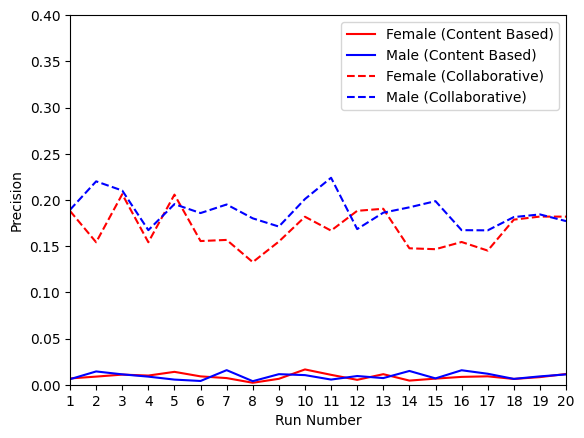

In [59]:
fig, ax = plt.subplots()
ax.plot(np.arange(epochs)+1, all_f_cb_p, 'r', label='Female (Content Based)')
ax.plot(np.arange(epochs)+1, all_m_cb_p, 'b', label='Male (Content Based)')
ax.plot(np.arange(epochs)+1, all_f_cf_p, 'r--', label='Female (Collaborative)')
ax.plot(np.arange(epochs)+1, all_m_cf_p, 'b--', label='Male (Collaborative)')
legend = ax.legend(loc='upper right')
ax.set_xlim([1,epochs])
ax.set_ylim([0, 0.4])
ax.set_xlabel('Run Number')
ax.set_ylabel('Precision')
plt.xticks(range(1,epochs+1))
plt.show()

In [60]:
print('Content Based Filtering Female:\n- Average Precision: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_f_cb_p), np.std(all_f_cb_p)))
print('Content Based Filtering Male:\n- Average Precision: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_m_cb_p), np.std(all_m_cb_p)))
print('Collaborative Filtering Female:\n- Average Precision: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_f_cf_p), np.std(all_f_cf_p)))
print('Collaborative Filtering Male:\n- Average Precision: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_m_cf_p), np.std(all_m_cf_p)))

Content Based Filtering Female:
- Average Precision: 0.009
- Standard Deviation: 0.003
Content Based Filtering Male:
- Average Precision: 0.009
- Standard Deviation: 0.004
Collaborative Filtering Female:
- Average Precision: 0.169
- Standard Deviation: 0.021
Collaborative Filtering Male:
- Average Precision: 0.188
- Standard Deviation: 0.016


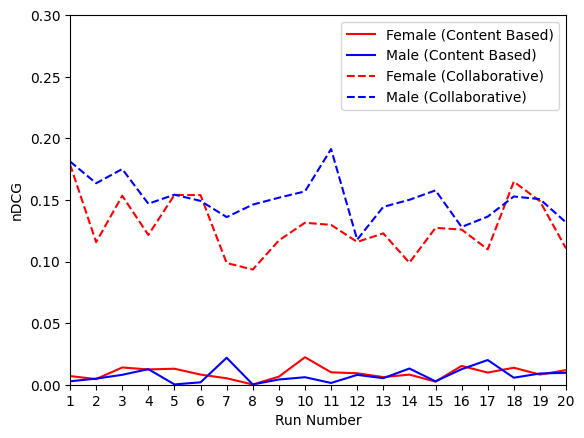

In [61]:
fig, ax = plt.subplots()
ax.plot(np.arange(epochs)+1, all_f_cb_n, 'r', label='Female (Content Based)')
ax.plot(np.arange(epochs)+1, all_m_cb_n, 'b', label='Male (Content Based)')
ax.plot(np.arange(epochs)+1, all_f_cf_n, 'r--', label='Female (Collaborative)')
ax.plot(np.arange(epochs)+1, all_m_cf_n, 'b--', label='Male (Collaborative)')
legend = ax.legend(loc='upper right')
ax.set_xlim([1,epochs])
ax.set_ylim([0, 0.3])
ax.set_xlabel('Run Number')
ax.set_ylabel('nDCG')
plt.xticks(range(1,epochs+1))
plt.show()

In [62]:
print('Content Based Filtering Female:\n- Average nDCG: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_f_cb_n), np.std(all_f_cb_n)))
print('Content Based Filtering Male:\n- Average nDCG: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_m_cb_n), np.std(all_m_cb_n)))
print('Collaborative Filtering Female:\n- Average nDCG: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_f_cf_n), np.std(all_f_cf_n)))
print('Collaborative Filtering Male:\n- Average nDCG: {:.3f}\n- Standard Deviation: {:.3f}'.format(np.mean(all_m_cf_n), np.std(all_m_cf_n)))

Content Based Filtering Female:
- Average nDCG: 0.009
- Standard Deviation: 0.005
Content Based Filtering Male:
- Average nDCG: 0.008
- Standard Deviation: 0.006
Collaborative Filtering Female:
- Average nDCG: 0.129
- Standard Deviation: 0.023
Collaborative Filtering Male:
- Average nDCG: 0.151
- Standard Deviation: 0.017


## Latent Dirichlet Allocation

Use a smaller tf-idf vectorizer for lda: only use genres for tokens, no combinations of genres.

In [ ]:
small_tf =  TfidfVectorizer(analyzer=lambda x: (c for i in range(1, 2) for c in combinations(x.split('|'), r=i)))

In [ ]:
small_analyzer = small_tf.build_analyzer()
[token for token in small_analyzer('Action|Crime|Sci-Fi')]

In [ ]:
small_X_tfidf = small_tf.fit_transform(movies['genres'])
small_X_tfidf.shape

3883 movies with 18 token (genres) weights.

In [ ]:
lda = LatentDirichletAllocation(n_components=10) # 5 topics

In [ ]:
X_lda = lda.fit_transform(small_X_tfidf)

In [ ]:
lda.components_.shape

The weights of 20 tokens in 10 latent topics.

In [ ]:
genres = small_tf.get_feature_names()

In [ ]:
for i, weights in enumerate(lda.components_):
    zipped = zip(genres, weights)
    top_genres_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:4]
    top_genres_list = list(dict(top_genres_key).keys())
    print("Topic " + str(i) + ": ", top_genres_list)

## Classical Evaluation Metrics

In [ ]:
all_rating_mat = test_rating_mat + known_rating_mat

In [ ]:
all_rating_mat = all_rating_mat.toarray()

In [ ]:
f_ids = f_users['user_id'].to_numpy()
m_ids = m_users['user_id'].to_numpy()

f_rating_mat = all_rating_mat.copy()
m_rating_mat = all_rating_mat.copy()

f_rating_mat[m_ids] = 0.0
m_rating_mat[f_ids] = 0.0

f_avg_item_ratings = np.true_divide(f_rating_mat.sum(0), (f_rating_mat != 0).sum(0))
m_avg_item_ratings = np.true_divide(m_rating_mat.sum(0), (m_rating_mat != 0).sum(0))

f_avg_item_ratings = np.nan_to_num(f_avg_item_ratings)
m_avg_item_ratings = np.nan_to_num(m_avg_item_ratings)

In [ ]:
f_est_mat = est_rating_mat.copy()
m_est_mat = est_rating_mat.copy()

f_est_mat[m_ids] = 0.0
m_est_mat[f_ids] = 0.0

f_avg_est_ratings = np.true_divide(f_est_mat.sum(0), (f_est_mat != 0).sum(0))
m_avg_est_ratings = np.true_divide(m_est_mat.sum(0), (m_est_mat != 0).sum(0))

f_avg_est_ratings = np.nan_to_num(f_avg_est_ratings)
m_avg_est_ratings = np.nan_to_num(m_avg_est_ratings)

**Value Unfairness**

In [ ]:
np.mean(np.abs((f_avg_est_ratings - f_avg_item_ratings) - (m_avg_est_ratings - m_avg_item_ratings)))

**Underestimation Unfairness**

In [ ]:
f_avg_est_ratings - f_avg_item_ratings

In [ ]:
np.mean(np.abs(np.maximum(np.zeros((3883,)), (f_avg_item_ratings - f_avg_est_ratings)) - np.maximum(np.zeros((3883,)), (m_avg_item_ratings - m_avg_est_ratings))))

**Overestimation Unfairness**

In [ ]:
np.mean(np.abs(np.maximum(np.zeros((3883,)), (f_avg_est_ratings - f_avg_item_ratings)) - np.maximum(np.zeros((3883,)), (m_avg_est_ratings - m_avg_item_ratings))))